In [85]:
import keras
import sklearn
keras.__version__

'2.4.3'

In [2]:
import os, shutil, glob

In [87]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [88]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [3]:
# The directory where the datasets are stored
base = 'datasets'

# Directory with good basement pictures
good_basement_dir = os.path.join(base, 'good basement streetviews')

# Directory with good non basement pictures
good_non_basement_dir = os.path.join(base, 'good non basement streetviews')

# Directories for our training, validation
# and test splits. 
train_dir = os.path.join(base, 'train')
test_dir = os.path.join(base, 'test')
validation_dir = os.path.join(base, 'validation')

# Directory with our training basement pictures
train_basement_dir = os.path.join(train_dir, 'basement')

# Directory with our training non basement pictures
train_non_basement_dir = os.path.join(train_dir, 'non_basement')

# Directory with our validation basement pictures
validation_basement_dir = os.path.join(validation_dir, 'basement')

# Directory with our validation non basement pictures
validation_non_basement_dir = os.path.join(validation_dir, 'non_basement')

# Directory with our test basement pictures
test_basement_dir = os.path.join(test_dir, 'basement')

# Directory with our test non basement pictures
test_non_basement_dir = os.path.join(test_dir, 'non_basement')


In [9]:
import random
random.seed(340)
basement_files = os.listdir(good_basement_dir)
non_basement_files = os.listdir(good_non_basement_dir)

n_test = 40
n_validation = 60

basement_test_sample = random.sample(basement_files, n_test)
basement_train_sample = [file for file in basement_files if file not in basement_test_sample]
basement_validation_sample = random.sample(basement_train_sample, n_validation)

non_basement_test_sample = random.sample(non_basement_files, n_test)
non_basement_train_sample = [file for file in non_basement_files if file not in non_basement_test_sample]
non_basement_validation_sample = random.sample(non_basement_train_sample, n_validation)

for file in basement_test_sample:
    shutil.copy(os.path.join(good_basement_dir, file), test_basement_dir)
for file in basement_train_sample:
    shutil.copy(os.path.join(good_basement_dir, file), train_basement_dir)
for file in basement_validation_sample:
    shutil.copy(os.path.join(good_basement_dir, file), validation_basement_dir)
    os.remove(os.path.join(train_basement_dir, file))

for file in non_basement_test_sample:
    shutil.copy(os.path.join(good_non_basement_dir, file), test_non_basement_dir)
for file in non_basement_train_sample:
    shutil.copy(os.path.join(good_non_basement_dir, file), train_non_basement_dir)
for file in non_basement_validation_sample:
    shutil.copy(os.path.join(good_non_basement_dir, file), validation_non_basement_dir)
    os.remove(os.path.join(train_non_basement_dir, file))

In [10]:
print('total training images:', len(os.listdir(train_basement_dir) + os.listdir(train_non_basement_dir)))

total training images: 480


In [11]:
print('total validation images:', len(os.listdir(validation_basement_dir) + os.listdir(validation_non_basement_dir)))

total validation images: 120


In [12]:
print('total test images:', len(os.listdir(test_basement_dir) + os.listdir(test_non_basement_dir)))

total test images: 80


In [98]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [99]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [100]:
conv_base.trainable = False

In [101]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [102]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      #brightness_range=[0.3,0.9],
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [103]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [104]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=120,
      epochs=4,
      validation_data=validation_generator,
      validation_steps=30,
      verbose=2)

Epoch 1/4
120/120 - 104s - loss: 0.4942 - acc: 0.7667 - val_loss: 0.3631 - val_acc: 0.8667
Epoch 2/4
120/120 - 103s - loss: 0.3972 - acc: 0.8354 - val_loss: 0.3339 - val_acc: 0.8667
Epoch 3/4
120/120 - 103s - loss: 0.3570 - acc: 0.8417 - val_loss: 0.3189 - val_acc: 0.8583
Epoch 4/4
120/120 - 102s - loss: 0.3270 - acc: 0.8583 - val_loss: 0.3124 - val_acc: 0.8667


In [73]:
#model.save('')

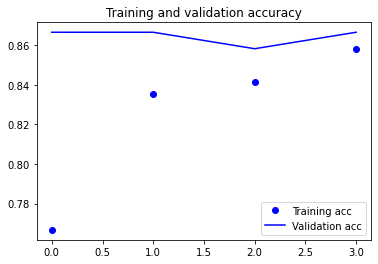

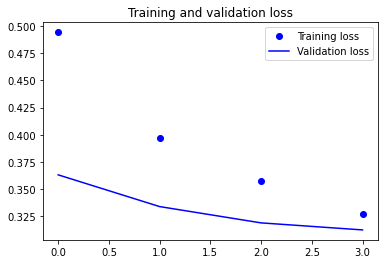

In [105]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

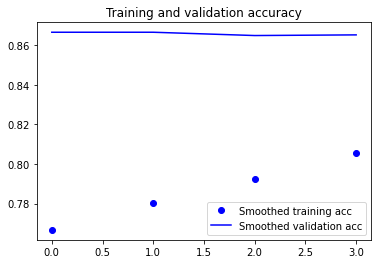

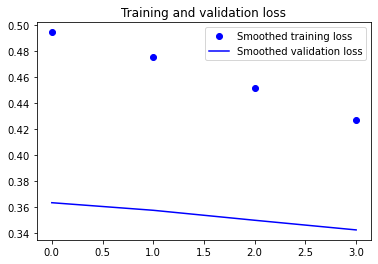

In [106]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [108]:
test_datagen2 = ImageDataGenerator(rescale=1./255)

test_generator2 = test_datagen2.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary',
        shuffle=False)

test_loss, test_acc = model.evaluate(test_generator2)
print('test acc:', test_acc)

probabilities = model.predict(test_generator2)

#print(probabilities)
from sklearn.metrics import confusion_matrix
import numpy as np
y_true = np.array([0] * 40 + [1] * 40)
y_pred = probabilities > 0.5

confusion_matrix(y_true, y_pred)

Found 80 images belonging to 2 classes.
8/8 [==============================] - 12s 1s/step - loss: 0.2863 - acc: 0.8875
test acc: 0.887499988079071


array([[32,  8],
       [ 1, 39]], dtype=int64)

In [13]:
#Removes all files from the training, validation and test folders
for file in os.listdir(train_basement_dir):
    os.remove(os.path.join(train_basement_dir, file))
for file in os.listdir(train_non_basement_dir):
    os.remove(os.path.join(train_non_basement_dir, file))

for file in os.listdir(validation_basement_dir):
    os.remove(os.path.join(validation_basement_dir, file))
for file in os.listdir(validation_non_basement_dir):
    os.remove(os.path.join(validation_non_basement_dir, file))

for file in os.listdir(test_basement_dir):
    os.remove(os.path.join(test_basement_dir, file))
for file in os.listdir(test_non_basement_dir):
    os.remove(os.path.join(test_non_basement_dir, file))